In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib as plt

sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque

import sys
from analysis_utils import *

Error importing rpy2


### First Training Experiment

In [ ]:
VERSION = '1A.5'
data = get_data(VERSION, '../experiment/data')
#ids = pd.read_csv(f'../experiment/data/human_raw/{VERSION}/identifiers.csv').set_index('pid')

TRIALS = pd.read_json('../experiment/experiment/static/json/rewards/increasing.json').set_index('trial_id').stateRewards

pdf = data['participants']
mdf = data['mouselab-mdp']

pretest = mdf.query('block == "pre_test"').copy()
training = mdf.query('block == "training"').copy()
posttest = mdf.query('block == "test"').copy()
pretest_and_training = mdf.query('block == "pre_test" or block == "training"').copy()

pretest.trial_index -= pretest.trial_index.min()
pretest.trial_index = pretest.trial_index.astype(int) + 1 
pretest.trial_id = pretest.trial_id.astype(int)

training.trial_index -= training.trial_index.min()
training.trial_index = training.trial_index.astype(int)
training.trial_id = training.trial_id.astype(int)

posttest.trial_index -= posttest.trial_index.min()
posttest.trial_index = posttest.trial_index.astype(int) + 1 
posttest.trial_id = posttest.trial_id.astype(int)

pretest_and_training.trial_index -= pretest_and_training.trial_index.min()
pretest_and_training.trial_index = pretest_and_training.trial_index.astype(int)
pretest_and_training.trial_id = pretest_and_training.trial_id.astype(int)


pdf['total_time'] = data['survey-text'].time_elapsed / 60000

def extract(q):
    return list(map(int, q['click']['state']['target']))

pretest['clicks'] = pretest.queries.apply(extract)
pretest['n_clicks'] = pretest.clicks.apply(len)

training['clicks'] = training.queries.apply(extract)
training['n_clicks'] = training.clicks.apply(len)

posttest['clicks'] = posttest.queries.apply(extract)
posttest['n_clicks'] = posttest.clicks.apply(len)

pretest_and_training['clicks'] = pretest_and_training.queries.apply(extract)
pretest_and_training['n_clicks'] = pretest_and_training.clicks.apply(len)

pdf['n_clicks'] = posttest.groupby('pid').n_clicks.mean()
pdf['score'] = posttest.groupby('pid').score.sum()

In [ ]:
len(pdf['pid'])

In [ ]:
pdf['pay'] = (0.75 + pdf.bonus)
pdf['wage'] = pdf.pay / (pdf.total_time / 60)
print(f'{pdf.wage.mean():.2f}  {pdf.wage.min():.2f}  {pdf.wage.std():.2f}')

sns.lmplot('n_clicks', 'wage', data=pdf)
plt.axhline(pdf.wage.mean(), c='r', ls='--')

print(pdf.bonus.mean())
print(pdf.bonus.std())

print(pdf.total_time.mean())
print(pdf.total_time.std())

In [ ]:
feedback_group  = pdf.query("with_feedback == True")
control_group = pdf.query("with_feedback == False")

n_feedback = len(feedback_group.pid)
n_control =  len(control_group.pid)
print('n_feedback: {}'.format(n_feedback))
print('n_control: {}'.format(n_control))

avg_score_training=posttest[posttest['pid'].isin(feedback_group.pid)].score.mean()
avg_score_control=posttest[posttest['pid'].isin(control_group.pid)].score.mean()

N_feedback = len(posttest[posttest['pid'].isin(feedback_group.pid)].score)
N_control = len(posttest[posttest['pid'].isin(control_group.pid)].score)

#t-test!!
t,p = stats.ttest_ind(posttest[posttest['pid'].isin(feedback_group.pid)].score,posttest[posttest['pid'].isin(control_group.pid)].score)

print("Participants who received feedback performed significantly better in the posttest than participants who didn't ({:3.1f} vs. {:3.1f}, t({})={:3.1f}, p={:4.4f}).".
      format(avg_score_training,avg_score_control,N_feedback+N_control-2,t,p))

#print(posttest[posttest['pid'].isin(feedback_group.pid)].score.std()/np.sqrt(n_feedback * 20))
#print(posttest[posttest['pid'].isin(control_group.pid)].score.std()/np.sqrt(n_control * 20))

In [ ]:
#print(pretest.score.mean())
#print(posttest.score.mean())

pretest["with_feedback"]=pd.Series(pretest['pid'].isin(feedback_group.pid))
training["with_feedback"]=pd.Series(training['pid'].isin(feedback_group.pid))
posttest["with_feedback"]=pd.Series(posttest['pid'].isin(feedback_group.pid))
pretest_and_training["with_feedback"]=pd.Series(pretest_and_training['pid'].isin(feedback_group.pid))

sns.set(font_scale=2)
sns.factorplot(x='trial_index', y='score', hue='with_feedback', data=pretest_and_training, size=8)
plt.xlabel('Trial Number')
plt.title('Learning Curves in Training Block')
plt.ylabel('Score')

matplotlib.rcParams.update({'font.size': 22})

plt.figure()
sns.barplot(y='score', x='with_feedback',data=posttest)
plt.xlabel('')
plt.xticks([0,1],['No Feedback','Feedback'])
plt.ylabel('Avg. Score (points/trial)')
plt.title('Performance in the Post Test')

#print(n_feedback)
#print(n_control)

In [ ]:
import statsmodels.formula.api as smf

model = smf.ols('score ~ trial_index * with_feedback', data=pretest_and_training).fit()
model.summary()

In [ ]:
pids = pdf.pid
improvement = np.array([])
received_FB = np.array([])
for p in pids:
    improvement = np.append(improvement,[pretest_and_training.query("trial_index==10 and pid == {}".format(p)).score.mean() - pretest_and_training.query("trial_index==0 and pid == {}".format(p)).score.mean()]) 
    received_FB = np.append(received_FB, [p in feedback_group.pid])   

avg_improvement_with_FB = np.mean(improvement[received_FB==True])
avg_improvement_without_FB = np.mean(improvement[received_FB==False])

t,p = stats.ttest_ind(improvement[received_FB==True],improvement[received_FB==False])
df = n_feedback+n_control-2
print("Participants in the feedback condition improved significantly more during the training block than participants in the control condition (+{:4.3} vs. +{:4.3}  t({})={:4.3}, p={:4.3}).".format(avg_improvement_with_FB,avg_improvement_without_FB,df,t,p))

## Analyze the effect of training on post-test strategy

In [ ]:
import statsmodels.stats.proportion as proportion

trial_ids = posttest['clicks'].keys()

level_of_first_click = np.array([])
nr_clicks = np.array([])

nodes_by_level = dict()
nodes_by_level[0]=[0]
nodes_by_level[1]=[1,5,9]
nodes_by_level[2]=[2,6,10]
nodes_by_level[3]=[3,4,7,8,11,12]

for t in trial_ids:
    clicks = posttest['clicks'][t]
    
    nr_clicks = np.append(nr_clicks,[len(clicks)])
    
    if len(clicks)>0:    
        first_click = clicks[0]
        for l in range(len(nodes_by_level)):
            if first_click in nodes_by_level[l]:
                level_of_first_click = np.append(level_of_first_click,[l])
    else:
            level_of_first_click = np.append(level_of_first_click,[0])

posttest['level_of_first_click'] = pd.Series(level_of_first_click)
            
np.mean(level_of_first_click[posttest.with_feedback]==3)
np.mean(level_of_first_click[posttest.with_feedback==False]==3)

plt.figure()
sns.distplot(level_of_first_click[posttest.with_feedback==True], color='green', kde=False, rug=True,label='with feedback');
sns.distplot(level_of_first_click[posttest.with_feedback==False], color='red', kde=False, rug=True,label='no feedback');
plt.legend()
plt.xlabel('Level of the first click (0: no click, 3: leaf node)')

click_levels = [0,1,2,3]
z = dict()
p = dict()

nr_observations_by_level_FB = np.array(click_levels)
nr_observations_by_level_noFB = np.array(click_levels)

for l in click_levels:
    counts= np.array([ np.sum(level_of_first_click[posttest.with_feedback==True]==l),
             np.sum(level_of_first_click[posttest.with_feedback==False]==l)])
    
    nobs = np.array([ len(level_of_first_click[posttest.with_feedback==True]),
             len(level_of_first_click[posttest.with_feedback==False])])
    
    nr_observations_by_level_FB[l] = counts[0]
    nr_observations_by_level_noFB[l] = counts[1]

    
    z[l],p[l] = proportion.proportions_ztest(counts, nobs)

    print('{:5.2}% vs. {:5.2}% (Z={:4.3}, p={:4.3})'.format(100*counts[0]/nobs[0], 100*counts[1]/nobs[1], z[l],p[l]))

plt.figure()
sns.barplot(x='with_feedback',y='n_clicks',data=posttest)

avg_nr_clicks_FB=posttest[posttest['pid'].isin(feedback_group.pid)].n_clicks.mean()
avg_nr_clicks_noFB=posttest[posttest['pid'].isin(control_group.pid)].n_clicks.mean()

std_nr_clicks_FB=posttest[posttest['pid'].isin(feedback_group.pid)].n_clicks.std()
std_nr_clicks_noFB=posttest[posttest['pid'].isin(control_group.pid)].n_clicks.std()


t,p = stats.ttest_ind(posttest[posttest['pid'].isin(feedback_group.pid)].n_clicks,posttest[posttest['pid'].isin(control_group.pid)].n_clicks)
print("{:3.2} +- {:3.2} vs. {:3.2} +- {:3.2} (t({})={:3.2}, p={:5.4})".format(
        avg_nr_clicks_FB,avg_nr_clicks_noFB,std_nr_clicks_FB,std_nr_clicks_noFB,
        N_feedback+N_control-2, t, p))

In [ ]:
#todo: test if FB increased the frequency of backward planning beyond reducing the frequency of no planning

click_levels = [1,2,3]

rel_freq_FB = np.array([0.0,0.0,0.0])
rel_freq_no_FB = np.array([0.0,0.0,0.0])

z = dict()
p = dict()

for l in click_levels:  
    print(l)
    rel_freq_FB[l-1] = float(nr_observations_by_level_FB[l])/float(np.sum(nr_observations_by_level_FB[1:]))
    rel_freq_no_FB[l-1] = float(nr_observations_by_level_noFB[l])/float(np.sum(nr_observations_by_level_noFB[1:]))
    counts = [nr_observations_by_level_FB[l], nr_observations_by_level_noFB[l]]
    nobs = [np.sum(nr_observations_by_level_FB[1:]),np.sum(nr_observations_by_level_noFB[1:])]
    z[l],p[l] = proportion.proportions_ztest(counts, nobs)
    print('{:5.3}% vs. {:5.3}% (Z={:4.3}, p={:4.3})'.format(100*counts[0]/nobs[0], 100*counts[1]/nobs[1], z[l],p[l]))

                                                          

sns.barplot(x=[1,2,3],y=rel_freq_no_FB,label='no feedback')
plt.xlabel('Started planning from step #')
plt.title('Without Feedback')
plt.ylabel('Frequency of First Click')

plt.figure()
sns.barplot(x=[1,2,3],y=rel_freq_FB,label='feedback')    
#plt.legend()
plt.xlabel('Started planning from step #')
plt.title('With Feedback')
plt.ylabel('Frequency of First Click')



## Near-Transfer Experiment

In [ ]:
VERSION = 'T1.1'
data = get_data(VERSION, '../near_transfer/data')
#ids = pd.read_csv(f'../experiment/data/human_raw/{VERSION}/identifiers.csv').set_index('pid')

TRAINING_TRIALS = pd.read_json('../near_transfer/experiment/static/json/mcrl_trials/increasing.json').set_index('trial_id').stateRewards
TEST_TRIALS = pd.read_json('../near_transfer/experiment/static/json/rewards/31123_increasing1.json').set_index('trial_id').stateRewards

pdf = data['participants']
mdf = data['mouselab-mdp']

pretest = mdf.query('block == "pre_test"').copy()
training = mdf.query('block == "training"').copy()
posttest = mdf.query('block == "test"').copy()
pretest_and_training = mdf.query('block == "pre_test" or block == "training"').copy()

pretest.trial_index -= pretest.trial_index.min()
pretest.trial_index = pretest.trial_index.astype(int) + 1 
pretest.trial_id = pretest.trial_id.astype(int)

training.trial_index -= training.trial_index.min()
training.trial_index = training.trial_index.astype(int)
training.trial_id = training.trial_id.astype(int)

posttest.trial_index -= posttest.trial_index.min()
posttest.trial_index = posttest.trial_index.astype(int) + 1 
posttest.trial_id = posttest.trial_id.astype(int)

pretest_and_training.trial_index -= pretest_and_training.trial_index.min()
pretest_and_training.trial_index = pretest_and_training.trial_index.astype(int)
pretest_and_training.trial_id = pretest_and_training.trial_id.astype(int)


pdf['total_time'] = data['survey-text'].time_elapsed / 60000

def extract(q):
    return list(map(int, q['click']['state']['target']))

pretest['clicks'] = pretest.queries.apply(extract)
pretest['n_clicks'] = pretest.clicks.apply(len)

training['clicks'] = training.queries.apply(extract)
training['n_clicks'] = training.clicks.apply(len)

posttest['clicks'] = posttest.queries.apply(extract)
posttest['n_clicks'] = posttest.clicks.apply(len)

pretest_and_training['clicks'] = pretest_and_training.queries.apply(extract)
pretest_and_training['n_clicks'] = pretest_and_training.clicks.apply(len)

pdf['n_clicks'] = posttest.groupby('pid').n_clicks.mean()
pdf['score'] = posttest.groupby('pid').score.sum()

nr_participants = len(pdf['pid'])

In [ ]:
pdf['pay'] = (0.8 + pdf.bonus)
pdf['wage'] = pdf.pay / (pdf.total_time / 60)

print(f'Average wage: {pdf.wage.mean():.2f}, Minimum wage:  {pdf.wage.min():.2f}, STD of wage:  {pdf.wage.std():.2f}')

sns.lmplot('n_clicks', 'wage', data=pdf)
plt.axhline(pdf.wage.mean(), c='r', ls='--')

print("Average bonus: ${:5.4} +/- ${:4.3}".format(pdf.bonus.mean(),pdf.bonus.std()))

print("Average duration: {:4.3} +/- {:4.3} minutes".format(pdf.total_time.mean(),pdf.total_time.std()))

In [ ]:
feedback_group  = pdf.query("with_feedback == True")
control_group = pdf.query("with_feedback == False")

n_feedback = len(feedback_group.pid)
n_control =  len(control_group.pid)
print('n_feedback: {}'.format(n_feedback))
print('n_control: {}'.format(n_control))

avg_score_training=posttest[posttest['pid'].isin(feedback_group.pid)].score.mean()
avg_score_control=posttest[posttest['pid'].isin(control_group.pid)].score.mean()

N_feedback = len(posttest[posttest['pid'].isin(feedback_group.pid)].score)
N_control = len(posttest[posttest['pid'].isin(control_group.pid)].score)

#t-test!!
t,p = stats.ttest_ind(posttest[posttest['pid'].isin(feedback_group.pid)].score,posttest[posttest['pid'].isin(control_group.pid)].score)

print("Participants who received feedback in the training block performed significantly better in the transfer task than participants who didn't ({:3.1f} $/trial vs. {:3.1f} $/trial, t({})={:3.1f}, p={:4.4f}).".
      format(avg_score_training,avg_score_control,N_feedback+N_control-2,t,p))

#print(posttest[posttest['pid'].isin(feedback_group.pid)].score.std()/np.sqrt(n_feedback * 20))
#print(posttest[posttest['pid'].isin(control_group.pid)].score.std()/np.sqrt(n_control * 20))

In [ ]:
#print(pretest.score.mean())
#print(posttest.score.mean())

pretest["with_feedback"]=pd.Series(pretest['pid'].isin(feedback_group.pid))
training["with_feedback"]=pd.Series(training['pid'].isin(feedback_group.pid))
posttest["with_feedback"]=pd.Series(posttest['pid'].isin(feedback_group.pid))
pretest_and_training["with_feedback"]=pd.Series(pretest_and_training['pid'].isin(feedback_group.pid))


posttest.to_pickle('posttest_experiment2')


sns.set(font_scale=2)
sns.factorplot(x='trial_index', y='score', hue='with_feedback', data=pretest_and_training, size=8)
plt.xlabel('Trial Number')
plt.title('Learning Curves in Training Block')
plt.ylabel('Score')

matplotlib.rcParams.update({'font.size': 22})

plt.figure()
sns.barplot(y='score', x='with_feedback',data=posttest)
plt.xlabel('')
plt.xticks([0,1],['Control','Cognitive Tutor'])
plt.ylabel('Avg. Score (points/trial)')
plt.title('Performance on the Transfer Task')

#print(n_feedback)
#print(n_control)

In [ ]:
import statsmodels.formula.api as smf

model = smf.ols('score ~ trial_index * with_feedback', data=pretest_and_training).fit()
model.summary()

#1.2146+1.1878

In [ ]:
pids = pdf.pid
improvement = np.array([])
received_FB = np.array([])
for p in pids:
    improvement = np.append(improvement,[pretest_and_training.query("trial_index==10 and pid == {}".format(p)).score.mean() - pretest_and_training.query("trial_index==1 and pid == {}".format(p)).score.mean()]) 
    received_FB = np.append(received_FB, [p in feedback_group.pid])   

avg_improvement_with_FB = np.mean(improvement[received_FB==True])
avg_improvement_without_FB = np.mean(improvement[received_FB==False])

t,p = stats.ttest_ind(improvement[received_FB==True],improvement[received_FB==False])
df = n_feedback+n_control-2
print("Participants in the feedback condition improved significantly more during the training block than participants in the control condition (+{:4.3} vs. +{:4.3}  t({})={:4.3}, p={:4.3}).".format(avg_improvement_with_FB,avg_improvement_without_FB,df,t,p))

In [ ]:
pids = pdf.pid
improvement = np.array([])
received_FB = np.array([])
for p in pids:
    improvement = np.append(improvement,[posttest.query("pid == {}".format(p)).score.mean() - pretest.query("pid == {}".format(p)).score.mean()]) 
    received_FB = np.append(received_FB, [p in feedback_group.pid])   

posttest['improvement']=pd.Series(improvement)
posttest['received_FB']=pd.Series(received_FB)
    
avg_improvement_with_FB = np.mean(improvement[received_FB==True])
avg_improvement_without_FB = np.mean(improvement[received_FB==False])

t,p = stats.ttest_ind(improvement[received_FB==True],improvement[received_FB==False])
df = n_feedback+n_control-2
print("Participants in the feedback condition improved significantly more on the transfer task than participants in the control condition (+{:4.3} vs. +{:4.3},  t({})={:4.3}, p={:4.3}).".format(avg_improvement_with_FB,avg_improvement_without_FB,df,t,p))

matplotlib.rcParams.update({'font.size': 22})

plt.figure()
sns.barplot(y='improvement', x='received_FB',data=posttest,ci=95,n_boot=1000)
plt.xlabel('')
plt.xticks([0,1],['Control','Cognitive Tutor'])
plt.ylabel('Post - Pre (points/trial)')
plt.title('Performance on the Transfer Task')


sns.set(font_scale=2)
sns.factorplot(x='trial_index', y='score', hue='with_feedback', data=posttest, size=8)
plt.xlabel('Trial Number')
plt.title('Learning Curves in Transfer Block')
plt.ylabel('Score')

In [ ]:
plt.figure()
sns.distplot(posttest[posttest.with_feedback].score,color='g',label='tutor')
sns.distplot(posttest[posttest.with_feedback==False].score,color='r',label='control')
plt.legend(loc='upper left')
plt.xlabel('performance on transfer task')
plt.ylabel('Relative Frequency')

In [ ]:
import statsmodels.stats.proportion as proportion

trial_ids = posttest['clicks'].keys()

level_of_first_click = np.array([])
nr_clicks = np.array([])

#3-1-1-2-3 environment
nodes_by_level = dict()
nodes_by_level[0]=[0]
nodes_by_level[1]=[1,12,23]
nodes_by_level[2]=[2,13,24]
nodes_by_level[3]=[3,14,25]
nodes_by_level[4]=[4,8,15,19,26,30]
nodes_by_level[5]=[5,6,7,9,10,11,16,17,18,20,21,22,27,28,29,31,32,33]

for t in trial_ids:
    clicks = posttest['clicks'][t]
    
    nr_clicks = np.append(nr_clicks,[len(clicks)])
    
    if len(clicks)>0:    
        first_click = clicks[0]
        for l in range(len(nodes_by_level)):
            if first_click in nodes_by_level[l]:
                level_of_first_click = np.append(level_of_first_click,[l])
    else:
            level_of_first_click = np.append(level_of_first_click,[0])

posttest['level_of_first_click'] = pd.Series(level_of_first_click)
            
np.mean(level_of_first_click[posttest.with_feedback==True]==3)
np.mean(level_of_first_click[posttest.with_feedback==False]==3)

plt.figure()
sns.distplot(level_of_first_click[posttest.with_feedback==True], color='green', kde=False, rug=True,label='with feedback');
sns.distplot(level_of_first_click[posttest.with_feedback==False], color='red', kde=False, rug=True,label='no feedback');
plt.legend()
plt.xlabel('Level of the first click (0: no click, 5: leaf node)')

click_levels = [0,1,2,3,4,5]
leaf_level = 5;
z = dict()
p = dict()

nr_observations_by_level_FB = np.array(click_levels)
nr_observations_by_level_noFB = np.array(click_levels)

for l in click_levels:
    counts= np.array([ np.sum(level_of_first_click[posttest.with_feedback==True]==l),
             np.sum(level_of_first_click[posttest.with_feedback==False]==l)])
    
    nobs = np.array([ len(level_of_first_click[posttest.with_feedback==True]),
             len(level_of_first_click[posttest.with_feedback==False])])
    
    nr_observations_by_level_FB[l] = counts[0]
    nr_observations_by_level_noFB[l] = counts[1]

    
    z[l],p[l] = proportion.proportions_ztest(counts, nobs)

    print('level {}: {:5.2}% vs. {:5.2}% (Z={:4.3}, p={:4.3})'.format(l,100*counts[0]/nobs[0], 100*counts[1]/nobs[1], z[l],p[l]))

plt.figure()
sns.barplot(x='with_feedback',y='n_clicks',data=posttest)

avg_nr_clicks_FB=posttest[posttest['pid'].isin(feedback_group.pid)].n_clicks.mean()
avg_nr_clicks_noFB=posttest[posttest['pid'].isin(control_group.pid)].n_clicks.mean()

std_nr_clicks_FB=posttest[posttest['pid'].isin(feedback_group.pid)].n_clicks.std()
std_nr_clicks_noFB=posttest[posttest['pid'].isin(control_group.pid)].n_clicks.std()


t,p = stats.ttest_ind(posttest[posttest['pid'].isin(feedback_group.pid)].n_clicks,posttest[posttest['pid'].isin(control_group.pid)].n_clicks)
print("Avg. nr. clicks: {:3.2} +- {:3.2} vs. {:3.2} +- {:3.2} (t({})={:3.2}, p={:5.4})".format(
        avg_nr_clicks_FB,avg_nr_clicks_noFB,std_nr_clicks_FB,std_nr_clicks_noFB,
        N_feedback+N_control-2, t, p))

In [ ]:
#todo: test if FB increased the frequency of backward planning beyond reducing the frequency of no planning

click_levels = [1,2,3,4,5]

rel_freq_FB = np.array([0.0,0.0,0.0,0.0,0.0])
rel_freq_no_FB = np.array([0.0,0.0,0.0,0.0,0.0])

z = dict()
p = dict()

for l in click_levels:  
    print(l)
    rel_freq_FB[l-1] = float(nr_observations_by_level_FB[l])/float(np.sum(nr_observations_by_level_FB[1:]))
    rel_freq_no_FB[l-1] = float(nr_observations_by_level_noFB[l])/float(np.sum(nr_observations_by_level_noFB[1:]))
    counts = [nr_observations_by_level_FB[l], nr_observations_by_level_noFB[l]]
    nobs = [np.sum(nr_observations_by_level_FB[1:]),np.sum(nr_observations_by_level_noFB[1:])]
    z[l],p[l] = proportion.proportions_ztest(counts, nobs)
    print('{:5.3}% vs. {:5.3}% (Z={:4.3}, p={:4.3})'.format(100*counts[0]/nobs[0], 100*counts[1]/nobs[1], z[l],p[l]))

                                                          
sns.barplot(x=[1,2,3,4,5],y=rel_freq_no_FB,label='no feedback')
plt.xlabel('Started planning from step #')
plt.title('Without Feedback')
plt.ylabel('Frequency of First Click')

plt.figure()
sns.barplot(x=[1,2,3,4,5],y=rel_freq_FB,label='feedback')    
#plt.legend()
plt.xlabel('Started planning from step #')
plt.title('With Feedback')
plt.ylabel('Frequency of First Click')

# Retention Experiment

In [86]:
VERSION = 'R0.9'
data = get_data(VERSION, '../retention/data')
#ids = pd.read_csv(f'../experiment/data/human_raw/{VERSION}/identifiers.csv').set_index('pid')

TRAINING_TRIALS = pd.read_json('../retention/experiment/static/json/mcrl_trials/increasing.json').set_index('trial_id').stateRewards
TEST_TRIALS = pd.read_json('../retention/experiment/static/json/rewards/31123_increasing1.json').set_index('trial_id').stateRewards

pdf = data['participants']#.query('pid != 62').copy()
mdf = data['mouselab-mdp']#.query('pid != 62').copy()

pretest = mdf.query('block == "pre_test"').copy()
training = mdf.query('block == "training"').copy()
posttest = mdf.query('block == "test"').copy()
pretest_and_training = mdf.query('block == "pre_test" or block == "training"').copy()

pretest.trial_index -= pretest.trial_index.min()
pretest.trial_index = pretest.trial_index.astype(int) + 1 
pretest.trial_id = pretest.trial_id.astype(int)

training.trial_index -= training.trial_index.min()
training.trial_index = training.trial_index.astype(int)
training.trial_id = training.trial_id.astype(int)

posttest.trial_index -= posttest.trial_index.min()
posttest.trial_index = posttest.trial_index.astype(int) + 1 
posttest.trial_id = posttest.trial_id.astype(int)

pretest_and_training.trial_index -= pretest_and_training.trial_index.min()
pretest_and_training.trial_index = pretest_and_training.trial_index.astype(int)
pretest_and_training.trial_id = pretest_and_training.trial_id.astype(int)


pdf['total_time'] = data['survey-text'].time_elapsed / 60000

def extract(q):
    return list(map(int, q['click']['state']['target']))

pretest['clicks'] = pretest.queries.apply(extract)
pretest['n_clicks'] = pretest.clicks.apply(len)

training['clicks'] = training.queries.apply(extract)
training['n_clicks'] = training.clicks.apply(len)

posttest['clicks'] = posttest.queries.apply(extract)
posttest['n_clicks'] = posttest.clicks.apply(len)

pretest_and_training['clicks'] = pretest_and_training.queries.apply(extract)
pretest_and_training['n_clicks'] = pretest_and_training.clicks.apply(len)

pdf['n_clicks'] = posttest.groupby('pid').n_clicks.mean()
pdf['score'] = posttest.groupby('pid').score.sum()

stage = []
start_times = pdf['startTime']
for t in start_times:
    if t[0:3]=='Wed' or t[0:3]=="Fri":
        stage.append(1)
    else:
        stage.append(2)

pdf['stage']=pd.Series(stage)

excluded = 62
experimental_group = set(pdf.query('feedback == True and stage==1' ).pid)
control_group = set(pdf.query('feedback == False and stage==1').pid)
control_group.remove(excluded)

posttest['with_feedback']=pd.Series(posttest['pid'].isin(experimental_group))

nr_participants = len(pdf['pid'])
print("{} participants in the experimental group.".format(len(experimental_group)))
print("{} participants in the control group.".format(len(control_group)))

50 participants in the experimental group.
49 participants in the control group.


In [87]:
pay_df = pd.DataFrame()

pay = np.array(pdf.query('stage==2').bonus)
pay_df['pid'] = pdf.query('stage==2').pid

base_pay = np.array([])
for t in pdf.query("stage==2").startTime:
    if t[0:3]=='Sat':
        base_pay=np.append(base_pay,[0.21])
    else:
        base_pay=np.append(base_pay,[0.11])

pay_df['total_pay'] = pd.Series(pay + base_pay)
pay_df['bonus'] = pay_df['total_pay'] - (1.89 + base_pay)

total_time = np.array([])

for p in pay_df['pid']:
    total_time = np.append(total_time,[pdf.query('pid=={}'.format(p)).total_time.sum()])
    
pay_df['total_time']=pd.Series(total_time)

pay_df['wage']=pd.Series(pay_df.total_pay/ pay_df.total_time)

print("Average total time: {:4.3} +/- {:3.2} minutes".format(pay_df.total_time.mean(),pay_df.total_time.std()))
print("Average bonus: ${:4.3} +/- ${:5.4}".format(pay_df.bonus.mean(),pay_df.bonus.std()))


Average total time: 16.3 +/- 5.4 minutes
Average bonus: $2.29 +/- $0.8748


len(set(posttest[posttest['pid'].isin(control_group)].pid))

In [90]:
n_feedback = len(set(posttest[posttest['pid'].isin(experimental_group)].pid))
n_control =  len(set(posttest[posttest['pid'].isin(control_group)].pid))
print('n_feedback: {}'.format(n_feedback))
print('n_control: {}'.format(n_control))

avg_score_training=posttest[posttest['pid'].isin(experimental_group)].score.mean()
avg_score_control=posttest[posttest['pid'].isin(control_group)].score.mean()

N_feedback = len(posttest[posttest['pid'].isin(experimental_group)].score)
N_control = len(posttest[posttest['pid'].isin(control_group)].score)

t,p = stats.ttest_ind(posttest[posttest['pid'].isin(experimental_group)].score,posttest[posttest['pid'].isin(control_group)].score)

print("After about 24h, participants who had received feedback in the training block still performed significantly better on the transfer task than participants who had practiced without feedback ({:3.1f} $/trial vs. {:3.1f} $/trial, t({})={:3.1f}, p={:4.4f}).".
      format(avg_score_training,avg_score_control,N_feedback+N_control-2,t,p))

#print(posttest[posttest['pid'].isin(feedback_group.pid)].score.std()/np.sqrt(n_feedback * 20))
#print(posttest[posttest['pid'].isin(control_group.pid)].score.std()/np.sqrt(n_control * 20))

n_feedback: 43
n_control: 36
After about 24h, participants who had received feedback in the training block still performed significantly better on the transfer task than participants who had practiced without feedback (39.9 $/trial vs. 29.1 $/trial, t(1578)=7.8, p=0.0000).


Text(0.5,1,'Performance on the Transfer Task after 24 hours')

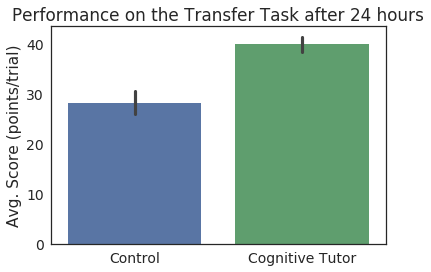

In [89]:
plt.figure()
sns.barplot(y='score', x='with_feedback',data=posttest)
plt.xlabel('')
plt.xticks([0,1],['Control','Cognitive Tutor'])
plt.ylabel('Avg. Score (points/trial)')
plt.title('Performance on the Transfer Task after 24 hours')

In [91]:
# Compare retained transfer effect to immediate transfer effect

posttest_experiment2=pd.read_pickle('posttest_experiment2')

immediate_benefit = posttest_experiment2.query('with_feedback == True').score.mean()-posttest_experiment2.query('with_feedback == False').score.mean()
sem_immediate_benefit = posttest_experiment2.query('with_feedback == True').score.std()/np.sqrt(len( posttest_experiment2.query('with_feedback == True').score)) + posttest_experiment2.query('with_feedback == False').score.std()/np.sqrt(len( posttest_experiment2.query('with_feedback == True').score)) 
retained_benefit = posttest.query('with_feedback == True').score.mean()-posttest.query('with_feedback == False').score.mean()
sem_retained_benefit = posttest.query('with_feedback == True').score.std()/np.sqrt(len( posttest.query('with_feedback == True').score))+posttest.query('with_feedback == False').score.std()/np.sqrt(len( posttest.query('with_feedback == True').score)) 

relative_retention = retained_benefit / immediate_benefit *100

z = (immediate_benefit-retained_benefit)/(sem_immediate_benefit+sem_retained_benefit) 
p = 1 - stats.norm.cdf(z)

print("The retained benefit of {:5.4} +/- {:4.3} was about {:4.3}% of the immediate benefit of {:4.3} +/- {:4.3}".format(retained_benefit,sem_retained_benefit,relative_retention,immediate_benefit,sem_immediate_benefit))

print("Given the large within-group variability in transfer task performance, the difference between immediate and retained transfer benefits was not statistically significant (Z={:4.3}, p={:4.4}).".format(z,p))


The retained benefit of 11.77 +/- 1.88 was about 97.4% of the immediate benefit of 12.1 +/- 3.55
Given the large within-group variability in transfer task performance, the difference between immediate and retained transfer benefits was not statistically significant (Z=0.0579, p=0.4769).


Participants in the feedback condition improved significantly more on the transfer task than participants in the control condition (+33.9 vs. +23.9,  t(77)=1.83, p=0.0684).


Text(0.5,1,'Improvement on the Transfer Task after 24h')

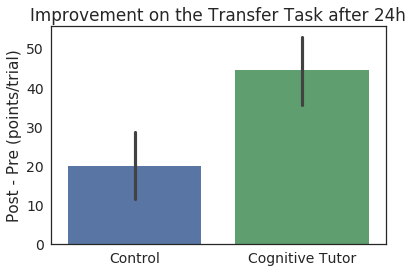

In [92]:
pids = pdf.pid
improvement = np.array([])
received_FB = np.array([])
for p in pids:
    improvement = np.append(improvement,[posttest.query("pid == {}".format(p)).score.mean() - pretest.query("pid == {}".format(p)).score.mean()]) 
    received_FB = np.append(received_FB, [p in experimental_group])   

posttest['improvement']=pd.Series(improvement)
posttest['received_FB']=pd.Series(received_FB)
    
avg_improvement_with_FB = np.nanmean(improvement[received_FB==True])
avg_improvement_without_FB = np.nanmean(improvement[received_FB==False])

t,p = stats.ttest_ind(improvement[received_FB==True],improvement[received_FB==False],nan_policy='omit')
df = n_feedback+n_control-2
print("Participants in the feedback condition improved significantly more on the transfer task than participants in the control condition (+{:4.3} vs. +{:4.3},  t({})={:4.3}, p={:4.3}).".format(avg_improvement_with_FB,avg_improvement_without_FB,df,t,p))

matplotlib.rcParams.update({'font.size': 22})

plt.figure()
sns.barplot(y='improvement', x='received_FB',data=posttest,ci=95,n_boot=1000)
plt.xlabel('')
plt.xticks([0,1],['Control','Cognitive Tutor'])
plt.ylabel('Post - Pre (points/trial)')
plt.title('Improvement on the Transfer Task after 24h')

Text(0,0.5,'Relative Frequency')

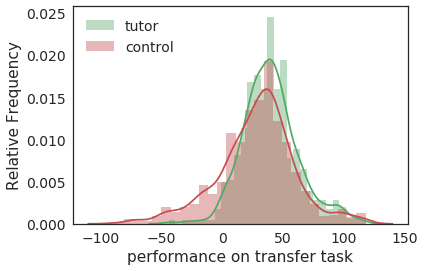

In [93]:
plt.figure()
sns.distplot(posttest[posttest.with_feedback].score,color='g',label='tutor')
sns.distplot(posttest[posttest.with_feedback==False].score,color='r',label='control')
plt.legend(loc='upper left')
plt.xlabel('performance on transfer task')
plt.ylabel('Relative Frequency')

level 0:   2.4% vs. 1.8e+01% (Z=-10.4, p=3.06e-25)
level 1:   2.3% vs. 2.1e+01% (Z=-11.9, p=1.21e-32)
level 2:  0.12% vs.  0.54% (Z=-1.52, p=0.13)
level 3:   2.7% vs.   1.9% (Z=1.04, p=0.299)
level 4:  0.23% vs.  0.27% (Z=-0.151, p=0.88)
level 5: 9.2e+01% vs. 5.9e+01% (Z=15.8, p=1.93e-56)
Avg. nr. clicks: 12.7 +- 7.3 vs. 7.8 +- 6.6 (t(1578)= 14.8, p=1.442e-46)


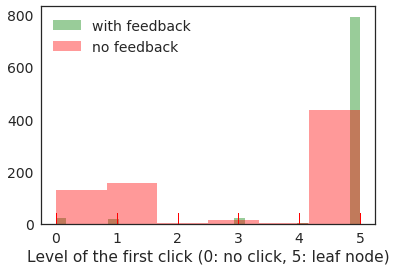

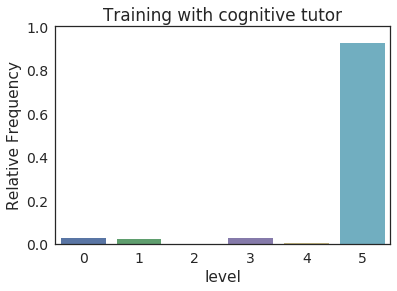

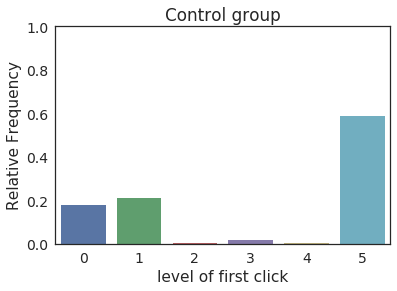

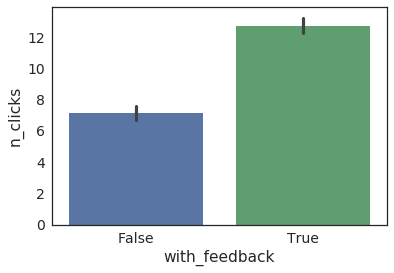

In [96]:
import statsmodels.stats.proportion as proportion

trial_ids = posttest['clicks'].keys()

level_of_first_click = np.array([])
nr_clicks = np.array([])

#3-1-1-2-3 environment
nodes_by_level = dict()
nodes_by_level[0]=[0]
nodes_by_level[1]=[1,12,23]
nodes_by_level[2]=[2,13,24]
nodes_by_level[3]=[3,14,25]
nodes_by_level[4]=[4,8,15,19,26,30]
nodes_by_level[5]=[5,6,7,9,10,11,16,17,18,20,21,22,27,28,29,31,32,33]

for t in trial_ids:
    clicks = posttest['clicks'][t]
    
    nr_clicks = np.append(nr_clicks,[len(clicks)])
    
    if len(clicks)>0:    
        first_click = clicks[0]
        for l in range(len(nodes_by_level)):
            if first_click in nodes_by_level[l]:
                level_of_first_click = np.append(level_of_first_click,[l])
    else:
            level_of_first_click = np.append(level_of_first_click,[0])

posttest['level_of_first_click'] = pd.Series(level_of_first_click)
            
np.mean(level_of_first_click[posttest.with_feedback==True]==3)
np.mean(level_of_first_click[posttest.with_feedback==False]==3)

plt.figure()
sns.distplot(level_of_first_click[posttest.with_feedback==True], color='green', kde=False, rug=True,label='with feedback');
plt.legend()
plt.xlabel('Level of the first click (0: no click, 5: leaf node)')
sns.distplot(level_of_first_click[posttest.with_feedback==False], color='red', kde=False, rug=True,label='no feedback');
plt.legend()
plt.xlabel('Level of the first click (0: no click, 5: leaf node)')

click_levels = [0,1,2,3,4,5]
leaf_level = 5;
z = dict()
p = dict()

nr_observations_by_level_FB = np.array(click_levels)
nr_observations_by_level_noFB = np.array(click_levels)

for l in click_levels:
    counts= np.array([ np.sum(level_of_first_click[posttest.with_feedback==True]==l),
             np.sum(level_of_first_click[posttest.with_feedback==False]==l)])
    
    nobs = np.array([ len(level_of_first_click[posttest.with_feedback==True]),
             len(level_of_first_click[posttest.with_feedback==False])])
    
    nr_observations_by_level_FB[l] = counts[0]
    nr_observations_by_level_noFB[l] = counts[1]

    
    z[l],p[l] = proportion.proportions_ztest(counts, nobs)

    print('level {}: {:5.2}% vs. {:5.2}% (Z={:4.3}, p={:4.3})'.format(l,100*counts[0]/nobs[0], 100*counts[1]/nobs[1], z[l],p[l]))

#plt.figure()
#sns.barplot(nr_observations_by_level_FB)
#plt.figure()
#sns.barplot(nr_observations_by_level_noFB)

rel_nr_obs_by_level_FB = []
rel_nr_obs_by_level_noFB = []

total_nr_observations_FB = np.sum(nr_observations_by_level_FB)
total_nr_observations_noFB = np.sum(nr_observations_by_level_noFB)

for l in range(6):
   rel_nr_obs_by_level_FB.append(nr_observations_by_level_FB[l]/total_nr_observations_FB) 
   rel_nr_obs_by_level_noFB.append(nr_observations_by_level_noFB[l]/total_nr_observations_noFB) 

temp=pd.DataFrame()
temp['level']=pd.Series([0,1,2,3,4,5])
temp['frequency_with_FB']=pd.Series(rel_nr_obs_by_level_FB)
temp['frequency_without_FB']=pd.Series(rel_nr_obs_by_level_noFB)

plt.figure()
sns.barplot(x='level',y='frequency_with_FB',data=temp)
plt.ylim([0,1])
plt.ylabel('Relative Frequency')
plt.title('Training with cognitive tutor')

plt.figure()
sns.barplot(x='level',y='frequency_without_FB',data=temp)
plt.ylim([0,1])
plt.xlabel('level of first click')
plt.ylabel('Relative Frequency')
plt.title('Control group')

    
plt.figure()
sns.barplot(x='with_feedback',y='n_clicks',data=posttest)

avg_nr_clicks_FB=posttest[posttest['pid'].isin(experimental_group)].n_clicks.mean()
avg_nr_clicks_noFB=posttest[posttest['pid'].isin(control_group)].n_clicks.mean()

std_nr_clicks_FB=posttest[posttest['pid'].isin(experimental_group)].n_clicks.std()
std_nr_clicks_noFB=posttest[posttest['pid'].isin(control_group)].n_clicks.std()


t,p = stats.ttest_ind(posttest[posttest['pid'].isin(experimental_group)].n_clicks,posttest[posttest['pid'].isin(control_group)].n_clicks)
print("Avg. nr. clicks: {:4.3} +- {:3.2} vs. {:3.2} +- {:3.2} (t({})={:5.3}, p={:5.4})".format(
        avg_nr_clicks_FB,avg_nr_clicks_noFB,std_nr_clicks_FB,std_nr_clicks_noFB,
        N_feedback+N_control-2, t, p))

In [43]:
rel_nr_obs_by_level_FB

[0.0,
 0.023809523809523808,
 0.0,
 0.052380952380952382,
 0.0023809523809523812,
 0.92142857142857137]

1
 2.38% vs.  25.5% (Z=-13.3, p=2.52e-40)
2
0.119% vs. 0.657% (Z=-1.72, p=0.0851)
3
 2.74% vs.   2.3% (Z=0.527, p=0.598)
4
0.238% vs. 0.328% (Z=-0.322, p=0.747)
5
 94.5% vs.  71.3% (Z=12.1, p=6.02e-34)


(0, 1)

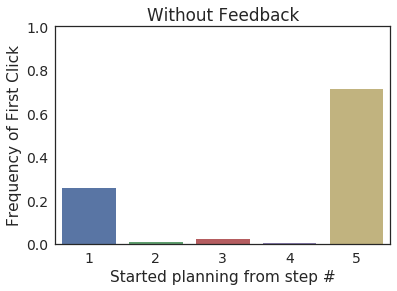

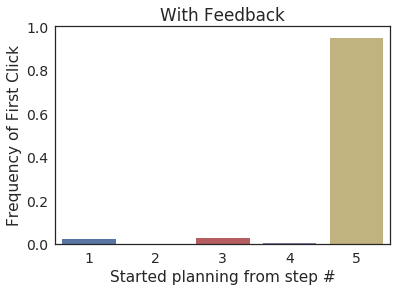

In [95]:
#todo: test if FB increased the frequency of backward planning beyond reducing the frequency of no planning

click_levels = [1,2,3,4,5]

rel_freq_FB = np.array([0.0,0.0,0.0,0.0,0.0])
rel_freq_no_FB = np.array([0.0,0.0,0.0,0.0,0.0])

z = dict()
p = dict()

for l in click_levels:  
    print(l)
    rel_freq_FB[l-1] = float(nr_observations_by_level_FB[l])/float(np.sum(nr_observations_by_level_FB[1:]))
    rel_freq_no_FB[l-1] = float(nr_observations_by_level_noFB[l])/float(np.sum(nr_observations_by_level_noFB[1:]))
    counts = [nr_observations_by_level_FB[l], nr_observations_by_level_noFB[l]]
    nobs = [np.sum(nr_observations_by_level_FB[1:]),np.sum(nr_observations_by_level_noFB[1:])]
    z[l],p[l] = proportion.proportions_ztest(counts, nobs)
    print('{:5.3}% vs. {:5.3}% (Z={:4.3}, p={:4.3})'.format(100*counts[0]/nobs[0], 100*counts[1]/nobs[1], z[l],p[l]))

                                                          
sns.barplot(x=[1,2,3,4,5],y=rel_freq_no_FB,label='no feedback')
plt.xlabel('Started planning from step #')
plt.title('Without Feedback')
plt.ylabel('Frequency of First Click')
plt.ylim([0,1])

plt.figure()
sns.barplot(x=[1,2,3,4,5],y=rel_freq_FB,label='feedback')    
#plt.legend()
plt.xlabel('Started planning from step #')
plt.title('With Feedback')
plt.ylabel('Frequency of First Click')
plt.ylim([0,1])